# Convolutional Neural Network Deep Learning for Automobile Image Classification
>*Developed and documented by Aria Kalantari.*<br> 
>*Submission for Project: Deep Learning for Image Classification*.<br> 
>*Written in August of 2023.*

___
### Importing Libraries

- **Numpy (`np`)**: Used for numerical operations and handling arrays. It's the backbone for many other libraries, including TensorFlow.
  
- **Random**: Provides functions to generate random numbers, which are used for data shuffling and augmentation.

- **Matplotlib (`plt`)**: Utilized for plotting graphs and displaying images, helpful in visualizing training progress and model performance.

- **OS**: Allows interaction with the operating system, used for file and directory operations, like reading files from a folder.

- **OpenCV (`cv2`)**: Used for image processing tasks such as rotating and resizing images.

- **TensorFlow (`tf`) and Keras**: TensorFlow is the main library for running machine learning algorithms, and Keras is a high-level API built on top of TensorFlow. They provide the tools to build, compile, and run neural network models.

  - **Sequential**: For initializing the neural network model.
  - **VGG16 and preprocess_input**: For implementing transfer learning.
  - **to_categorical**: For one-hot encoding of labels.
  - **Dense, Dropout, BatchNormalization**: Layers used in the neural network.
  - **ModelCheckpoint**: To save the best model during training.
  - **l2**: For L2 regularization.
  - **EarlyStopping**: To stop training when the model is not improving.
  
- **Scikit-learn (`train_test_split`)**: Used for splitting the dataset into training and testing sets.
  
These libraries together provide the necessary functionalities to build, train, and evaluate a convolutional neural network for image classification.

In [18]:
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.utils import to_categorical
from keras.layers import (
    Dense,
    Dense,
    Dropout,
    BatchNormalization,
)
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

___
### CarDatasetManager Class

This class is responsible for managing the car dataset, including tasks like loading images, preprocessing, and data augmentation. I am making sure to keep the RBG values of each image, it will slow the process down, but since BMW has blue in its logo it could improve overall accuracy.

#### Initialization (`__init__`):

Initializes the class with directories of BMW and Lexus images. It sets up empty lists for train and test images and labels.

#### Load Images (`load_images_from_directory`):

Loads images from a specified directory and assigns labels to them (BMW as 0 and Lexus as 1).

#### Load All Data (`load_all_data`):

Calls `load_images_from_directory` for both BMW and Lexus directories, then combines these images and labels.

#### Load and Split Data (`load_and_split_data`):

Loads images from both car directories, combines them, and then splits into training and test sets. It also performs data augmentation on the training set.

#### Resize Images (`resize_images`):

Resizes all images to a specified target size for uniformity.

#### Normalize Images (`normalize_images`):

Normalizes pixel values of images for faster and more stable training.

#### Augment Images (`augment_images`):

Performs image augmentation techniques like rotation, shifting, and flipping to make the model more robust.

#### Display Sample Images (`display_sample_images`):

Displays a specified number of original and resized sample images to check if data is loaded and resized correctly.

#### Split Data (`split_data`):

Splits the dataset into training and test sets using scikit-learn's `train_test_split`.

This class essentially prepares the data for training the Convolutional Neural Network (CNN).

In [19]:
class CarDatasetManager:
    # Class variables
    def __init__(self, bmw_dir: str, lexus_dir: str):
        self.BMW_DIR = bmw_dir
        self.LEXUS_DIR = lexus_dir
        self.train_images = []
        self.train_labels = []
        self.test_images = []
        self.test_labels = []

    # Load images from a directory
    def load_images_from_directory(self, directory, label) -> list:
        images = []
        labels = []
        for filename in os.listdir(directory):
            if filename.endswith(".jpg"):
                img_path = os.path.join(directory, filename)
                img = cv2.imread(img_path)
                # Convert from BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(label)
        return images, labels

    # Load training data
    def load_all_data(self):
        # 0 represents BMW
        bmw_images, bmw_labels = self.load_images_from_directory(self.BMW_DIR, 0)
        # 1 represents Lexus
        lexus_images, lexus_labels = self.load_images_from_directory(self.LEXUS_DIR, 1)

        self.images = bmw_images + lexus_images
        self.labels = bmw_labels + lexus_labels

    # Load and segregate data
    def load_and_split_data(self, test_size=0.2):
        # BMW Data (images, labels)
        bmw_images, bmw_labels = self.load_images_from_directory(self.BMW_DIR, 0)
        # Lexus Data (images, labels)
        lexus_images, lexus_labels = self.load_images_from_directory(self.LEXUS_DIR, 1)

        # Combine the data inluding images and labels
        all_images = bmw_images + lexus_images
        all_labels = bmw_labels + lexus_labels

        # Shuffle the data
        train_images, test_images, train_labels, test_labels = train_test_split(
            all_images,
            all_labels,
            test_size=test_size,
            random_state=42,
            stratify=all_labels,
        )

        # Augment the training images
        augmented_train_images = self.augment_images(train_images)

        # Append augmented images to the original training images
        train_images.extend(augmented_train_images)

        # Augment the labels accordingly
        train_labels.extend(train_labels)
        self.train_images = train_images
        self.train_labels = train_labels
        self.test_images = test_images
        self.test_labels = test_labels

    # Ensure that all images are of the same size to speed up training
    # Parameters: target_size - tuple of (width, height)
    def resize_images(self, images: list, target_size: tuple) -> list:
        return [cv2.resize(img, target_size) for img in images]

    # Normalize the images by dividing each pixel value by 255, this will make the training process faster
    def normalize_images(self):
        self.train_images = [img / 255.0 for img in self.train_images]
        self.test_images = [img / 255.0 for img in self.test_images]

    # Augment the images by rotating, shifting, zooming, and flipping them
    # This will make the model more robust to different lighting conditions and angles
    # Parameters: images - list of images to augment
    def augment_images(self, images: list) -> list:
        augmented_images = []

        for img in images:
            # Rotate
            M = cv2.getRotationMatrix2D(
                (img.shape[1] / 2, img.shape[0] / 2), np.random.uniform(-25, 25), 1
            )
            rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

            # Width and height shift
            M = np.float32(
                [[1, 0, np.random.randint(-20, 20)], [0, 1, np.random.randint(-20, 20)]]
            )
            shifted = cv2.warpAffine(rotated, M, (img.shape[1], img.shape[0]))

            # Brightness
            brightness = np.random.uniform(0.5, 1.5)
            bright = cv2.convertScaleAbs(shifted, alpha=brightness, beta=0)

            # Zoom
            if np.random.random() < 0.5:
                zoom_scale = np.random.uniform(0.9, 1.1)
                zoomed = cv2.resize(bright, None, fx=zoom_scale, fy=zoom_scale)
                if zoom_scale > 1:
                    crop_x = (zoomed.shape[1] - img.shape[1]) // 2
                    crop_y = (zoomed.shape[0] - img.shape[0]) // 2
                    zoomed = zoomed[
                        crop_y : crop_y + img.shape[0], crop_x : crop_x + img.shape[1]
                    ]
                else:
                    pad_x = (img.shape[1] - zoomed.shape[1]) // 2
                    pad_y = (img.shape[0] - zoomed.shape[0]) // 2
                    zoomed = cv2.copyMakeBorder(
                        zoomed,
                        pad_y,
                        pad_y,
                        pad_x,
                        pad_x,
                        cv2.BORDER_CONSTANT,
                        value=[0, 0, 0],
                    )
            else:
                zoomed = bright

            # Horizontal flip
            if np.random.random() < 0.5:
                flipped = cv2.flip(zoomed, 1)
            else:
                flipped = zoomed

            augmented_images.append(flipped)

        return augmented_images

    # Display sample images to check if the data is loaded correctly
    # Parameters: count - number of images to display, target_size - tuple of (width, height)

    def display_sample_images(self, count: int, target_size: tuple):
        plt.figure(figsize=(10, 5))

        # Randomly sample image indices
        indices = np.random.choice(len(self.images), count)

        # Display original images
        for i, idx in enumerate(indices):
            plt.subplot(2, count, i + 1)  # 2 rows: original and resized
            plt.imshow(self.images[idx])
            plt.title(f"Original {i+1}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()

        # Display resized images using the class's own "resize_images" method
        sample_images = [self.images[idx] for idx in indices]
        resized_images = self.resize_images(sample_images, target_size)
        plt.figure(figsize=(10, 5))
        for i, img in enumerate(resized_images):
            plt.subplot(2, count, i + 1)
            plt.imshow(img)
            plt.title(f"Resized {i+1}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()

    # Split the data into training and testing sets
    def split_data(self, test_size=0.2):
        (
            self.train_images,
            self.test_images,
            self.train_labels,
            self.test_labels,
        ) = train_test_split(
            self.images,
            self.labels,
            test_size=test_size,
            random_state=42,
            stratify=self.labels,
        )

___
### Data Preparation

**Initialize `CarDatasetManager`**: Create an object to manage BMW and Lexus image data.

**Load Data**: Use `load_all_data()` to import images and labels.

**Display Samples**: `display_sample_images()` shows 5 random images and their resized versions.

**Data Split**: `split_data()` partitions the data into training and test sets with a 20% test size.

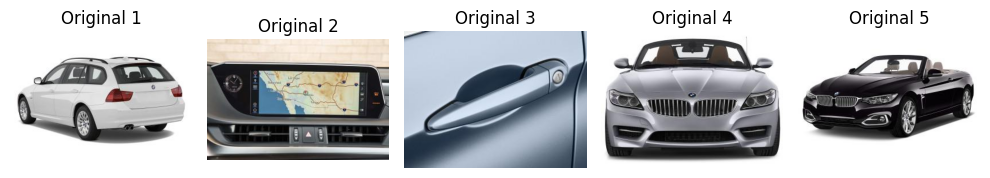

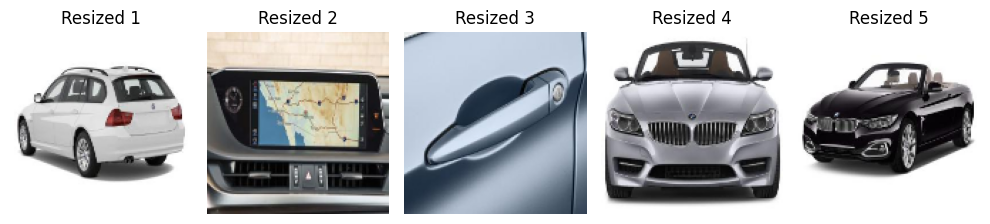

In [29]:
# Create a training dataset object, load training data and display sample images (with resized images below)
dataset = CarDatasetManager("Cars Dataset/BMW Dataset", "Cars Dataset/Lexus Dataset")
dataset.load_all_data()
dataset.display_sample_images(count=5, target_size=(128, 128))
dataset.split_data(test_size=0.2)

___
### CarBrandClassifier Class

This class is designed for constructing, training, and managing the Convolutional Neural Network (CNN) model for car brand classification.

#### Initialization (`__init__`):

Clears any existing TensorFlow sessions and initializes key variables such as the model directory and the model itself. Calls `_load_or_build()` to either load an existing model or build a new one.

#### Load or Build Model (`_load_or_build`):

Checks if a saved model exists. If so, it prompts the user to either load the existing model or build a new one. If no saved model exists, it proceeds to build a new one.

#### Build Model (`build_model`):

Constructs the CNN model using Keras' Sequential API. The architecture includes multiple dense layers with dropout and batch normalization for regularization. The model is compiled with Adam optimizer and categorical cross-entropy loss.

#### Save Model (`save_model`):

Saves the current state of the model to a specified directory.

#### Train Model (`train_model`):

Trains the model on the provided training data with optional validation data. This method utilizes Transfer Learning with VGG16, a pre-trained neural network model, to accelerate the training process and enhance performance. By using VGG16, we leverage its pre-existing understanding of image features, allowing our model to focus on learning the specific differentiators between BMW and Lexus cars. 

The method also implements early stopping and model checkpointing as callbacks to improve training efficiency and save the best-performing model. Returns the training history for further analysis.

In [21]:
class CarBrandClassifier:
    def __init__(self):
        tf.keras.backend.clear_session()
        self.model_dir = "model/model.h5"
        self.model = None
        self._load_or_build()

    # Either load the model if available or build it
    def _load_or_build(self):
        if os.path.exists(self.model_dir):
            user_input = input("Model exists! Do you want to load it? (Y/N): ")
            if user_input.lower() == "y":
                try:
                    self.model = tf.keras.models.load_model(self.model_dir)
                    print("Model loaded successfully!")
                except Exception as e:
                    print(f"Error loading model: {e}")
                    print("Building a new model instead...")
                    self.build_model()
            else:
                self.build_model()
        else:
            self.build_model()

    # Build the CNN model
    def build_model(self):
        self.model = Sequential()

        # Adjust the first Dense layer's input shape to the flattened VGG16 features
        self.model.add(
            Dense(
                256,
                activation="relu",
                input_shape=(25088,),
                kernel_regularizer=l2(0.01),
            )
        )
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))

        # Additional hidden layers with L2 regularization
        self.model.add(Dense(128, activation="relu", kernel_regularizer=l2(0.01)))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))

        self.model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.01)))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))

        # Output layer
        self.model.add(Dense(2, activation="softmax"))

        # Compile the model
        self.model.compile(
            optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
        )

    # Save the model to /model
    def save_model(self):
        self.model.save(self.model_dir)

    def train_model(
        self, train_images, train_labels, val_images=None, val_labels=None, epochs=25
    ) -> tf.keras.callbacks.History:
        # Convert labels to one-hot encoded format
        train_labels_onehot = tf.keras.utils.to_categorical(train_labels, 2)
        if val_images is not None and val_labels is not None:
            val_labels_onehot = tf.keras.utils.to_categorical(val_labels, 2)

        # Define callbacks (for early stopping)
        early_stopping = EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True
        )

        # Define callbacks (for saving the best model)
        checkpoint_callback = ModelCheckpoint(
            filepath=self.model_dir,
            save_best_only=True,
            monitor="val_accuracy",
            mode="max",
            verbose=1,
        )

        # If validation data is provided
        if val_images is not None and val_labels is not None:
            history = self.model.fit(
                np.array(train_images),
                np.array(train_labels_onehot),
                validation_data=(np.array(val_images), np.array(val_labels_onehot)),
                epochs=epochs,
                callbacks=[
                    checkpoint_callback,
                    early_stopping,
                ],  # Add early stopping here
            )
        else:
            # Even if you don't have validation data, you can still use early stopping
            # by monitoring the training loss. However, it's less effective this way.
            early_stopping.monitor = "loss"  # Change monitor to training loss
            history = self.model.fit(
                np.array(train_images),
                np.array(train_labels_onehot),
                epochs=epochs,
                callbacks=[
                    checkpoint_callback,
                    early_stopping,
                ]
            )

        return history

___
### Data Management and Model Training

**Initialize Data Manager**: Creates an instance of `CarDatasetManager` to manage the BMW and Lexus datasets.

**Load and Split Data**: Uses `load_and_split_data` method to load images and labels, and split them into training and test sets.

**Image Resizing**: Resizes training and test images to 28x28 pixels, and then further resizes them to 224x224 pixels to fit the input requirements VGG16.

**Preprocessing**: Uses VGG16's `preprocess_input` to perform necessary preprocessing on the images.

**Feature Extraction**: Utilizes VGG16's base model to extract features from the preprocessed images.

**Feature Flattening**: Flattens the extracted features to make them suitable for the fully connected layers in our custom model.

**Initialize Classifier**: Creates an instance of `CarBrandClassifier`.

**Model Training**: Trains the model using the extracted features and labels.

This block of code orchestrates the steps needed to prepare the data and train the model, ensuring the features are compatible with the VGG16 architecture.

In [22]:
# Initialize the data manager and load/split the data
data_manager = CarDatasetManager(
    "Cars Dataset/BMW Dataset", 
    "Cars Dataset/Lexus Dataset"
)

# Data management
data_manager.load_and_split_data()
train_images_resized = data_manager.resize_images(data_manager.train_images, (28, 28))
test_images_resized = data_manager.resize_images(data_manager.test_images, (28, 28))

# Resize the images to 224x224 for VGG16
train_images_for_vgg = np.array(data_manager.resize_images(train_images_resized, (224, 224)))
test_images_for_vgg = np.array(data_manager.resize_images(test_images_resized, (224, 224)))

# Preprocess the images for VGG16
train_images_for_vgg = preprocess_input(train_images_for_vgg)
test_images_for_vgg = preprocess_input(test_images_for_vgg)

# Load the VGG16 model without its top layers and extract features
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
train_features = base_model.predict(train_images_for_vgg)
test_features = base_model.predict(test_images_for_vgg)

# Flatten the extracted features
train_features_flattened = train_features.reshape(train_features.shape[0], -1)
test_features_flattened = test_features.reshape(test_features.shape[0], -1)

# Initialize the classifier
car_classifier = CarBrandClassifier()

# Train the model with the extracted features
history = car_classifier.train_model(
    train_features_flattened,
    data_manager.train_labels,
    test_features_flattened,
    data_manager.test_labels,
)


40/40 [==============================] - 76s 2s/step
Epoch 1/25
312/313 [============================>.] - ETA: 0s - loss: 5.4827 - accuracy: 0.5928
Epoch 1: val_accuracy improved from -inf to 0.72880, saving model to model/model.h5
313/313 [==============================] - 4s 11ms/step - loss: 5.4809 - accuracy: 0.5930 - val_loss: 3.4141 - val_accuracy: 0.7288
Epoch 2/25
 10/313 [..............................] - ETA: 4s - loss: 3.4367 - accuracy: 0.6875

/Users/packan/Desktop/Cars Deep Learning/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


307/313 [============================>.] - ETA: 0s - loss: 2.7259 - accuracy: 0.6928
Epoch 2: val_accuracy improved from 0.72880 to 0.74160, saving model to model/model.h5
313/313 [==============================] - 3s 9ms/step - loss: 2.7143 - accuracy: 0.6933 - val_loss: 2.0053 - val_accuracy: 0.7416
Epoch 3/25
310/313 [============================>.] - ETA: 0s - loss: 1.8115 - accuracy: 0.7310
Epoch 3: val_accuracy improved from 0.74160 to 0.75120, saving model to model/model.h5
313/313 [==============================] - 3s 10ms/step - loss: 1.8096 - accuracy: 0.7317 - val_loss: 1.5493 - val_accuracy: 0.7512
Epoch 4/25
307/313 [============================>.] - ETA: 0s - loss: 1.4338 - accuracy: 0.7451
Epoch 4: val_accuracy improved from 0.75120 to 0.79520, saving model to model/model.h5
313/313 [==============================] - 3s 8ms/step - loss: 1.4317 - accuracy: 0.7455 - val_loss: 1.2186 - val_accuracy: 0.7952
Epoch 5/25
310/313 [============================>.] - ETA: 0s - loss

### Training Summary

The model was trained for 25 epochs, showing improvements in both loss and accuracy metrics over time. The validation accuracy improved from an initial value of 72.88% in epoch 1 to 83.36% in epoch 25, while the training accuracy ranged from 59.28% to 77.93%. The model was saved at checkpoints where the validation accuracy improved, the best being at epoch 25 with a validation accuracy of 83.36%. The training also included early warnings about the legacy file format for model saving. Overall, the model showed a steady improvement in performance, reaching a relatively high level of accuracy by the final epoch.

___

### Model Evaluation

**One-Hot Encoding**: Converts the test labels into one-hot encoded format using Keras' `to_categorical` function. This makes them compatible with the output layer of the model.

**Model Evaluation**: Utilizes the `evaluate` method to assess the performance of the trained model on the test set, providing both loss and accuracy metrics.

**Display Metrics**: Prints out the calculated test loss and accuracy.

This section is crucial for understanding how well the model performs on unseen data. It gives an insight into the model's generalization capabilities.

In [23]:
# One-hot encode the test labels
test_labels_onehot = to_categorical(data_manager.test_labels)

# Evaluate the model
test_loss, test_accuracy = car_classifier.model.evaluate(
    test_features_flattened, test_labels_onehot
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100}%")

40/40 [==============================] - 0s 2ms/step - loss: 0.6843 - accuracy: 0.8336
Test Loss: 0.6842895746231079
Test Accuracy: 83.35999846458435%


___
### Plotting Model Performance Metrics

The code creates two plots to visualize the model's training and validation performance across epochs:

#### Accuracy Plot:
- Plots `history.history['accuracy']` and `history.history['val_accuracy']` for training and validation accuracy.
- Labels and a grid are added for readability.

#### Loss Plot:
- Plots `history.history['loss']` and `history.history['val_loss']` for training and validation loss.
- Labels and a grid are also added.

Both plots use a 12x6 figure size and are displayed using `plt.show()`.

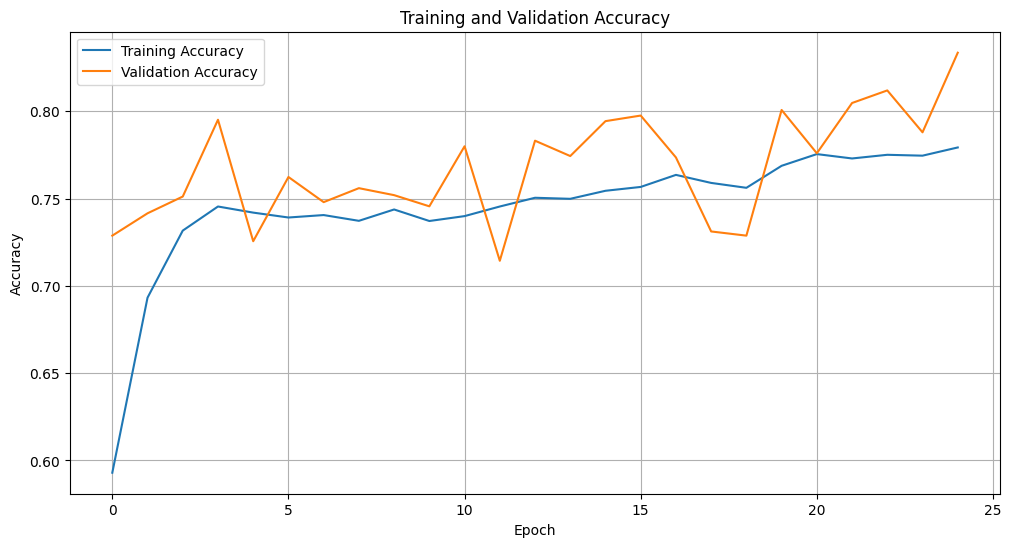

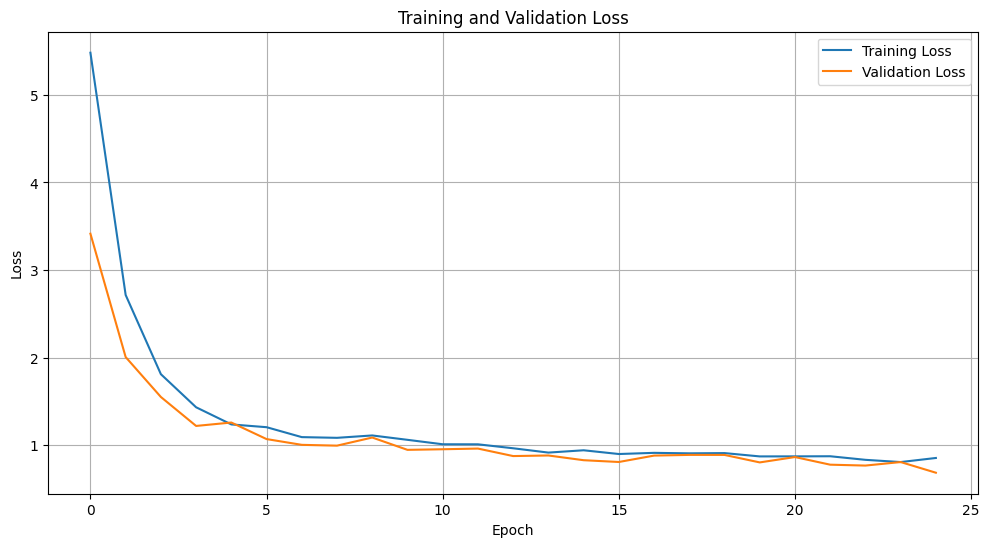

In [24]:
# Plotting training accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Analysis of Training and Validation Metrics

#### Accuracy Graph
As observed in the "accuracy" graph, both the training and validation lines follow a somewhat similar path. However, it's noteworthy that the validation accuracy does show occasional spikes. While it's not the absolute best, the model provides good enough results.

#### Loss Graph
In contrast, the "loss" graph indicates excellent alignment between the training and validation lines, suggesting that the model is learning well from the data.

In the following sections, we will further evaluate the model's performance in practice to determine its effectiveness.
___

### CarPredictionTester Class

This class is tasked with making predictions on untested images using a trained Keras model.

#### Initialization (`__init__`):
Initializes the class with the trained Keras model and the directory of untested images. It also lists all `.png` image files in the directory for testing.

#### Load and Preprocess Image (`load_and_preprocess_image`):
Loads an image from a given path, converts its color from BGR to RGB, resizes it to 224x224, and pre-processes it for the model.

#### Display Test Predictions (`display_test_predictions`):
This method displays five random test images alongside their predicted labels. It uses the trained model to predict the car brand (BMW or Lexus) and compares it with the true label inferred from the file name. Predictions are displayed as either "Correct" or "False" based on their accuracy.

This class serves as an effective tool for visually assessing how well the model performs on unseen data.

In [25]:
class CarPredictionTester:
    def __init__(self, model, untested_images_dir):
        self.model = model  # The trained Keras model
        self.untested_images_dir = (
            untested_images_dir  # Directory of untrained/test images
        )
        self.image_files = [
            f for f in os.listdir(self.untested_images_dir) if f.endswith(".png")
        ]

    def load_and_preprocess_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (224, 224))
        img_preprocessed = preprocess_input(np.expand_dims(img_resized, axis=0))
        return img, img_preprocessed

    def display_test_predictions(self):
        plt.figure(figsize=(20, 10))

        for i, image_file in enumerate(random.sample(self.image_files, 5)):
            image_path = os.path.join(self.untested_images_dir, image_file)
            img, img_preprocessed = self.load_and_preprocess_image(image_path)

            # Model prediction
            features = base_model.predict(img_preprocessed)
            features_flattened = features.reshape(features.shape[0], -1)
            prediction = self.model.predict(features_flattened)
            predicted_label = np.argmax(prediction)

            # Determine the true label from the file name
            true_label = 0 if "bmw" in image_file.lower() else 1

            # Determine if the prediction is correct or not
            is_correct = "(Correct)" if true_label == predicted_label else "(False)"

            # Display the image
            plt.subplot(1, 5, i + 1)
            plt.imshow(img)
            plt.title(
                f"Guessed {'BMW' if predicted_label == 0 else 'Lexus'} {is_correct}"
            )


        plt.show()

### Running Predictions on Untested Images

To evaluate how well our trained model performs on unseen data, we use the `CarPredictionTester` class.

Here, we specify the directory containing the untested images (`untrained_images_dir`). We then initialize a `CarPredictionTester` object (`tester`) with our trained model (`car_classifier.model`) and the directory of untested images. Finally, we call the `display_test_predictions()` method to visualize the model's predictions on a subset of these untested images.

1/1 [==============================] - 0s 11ms/step


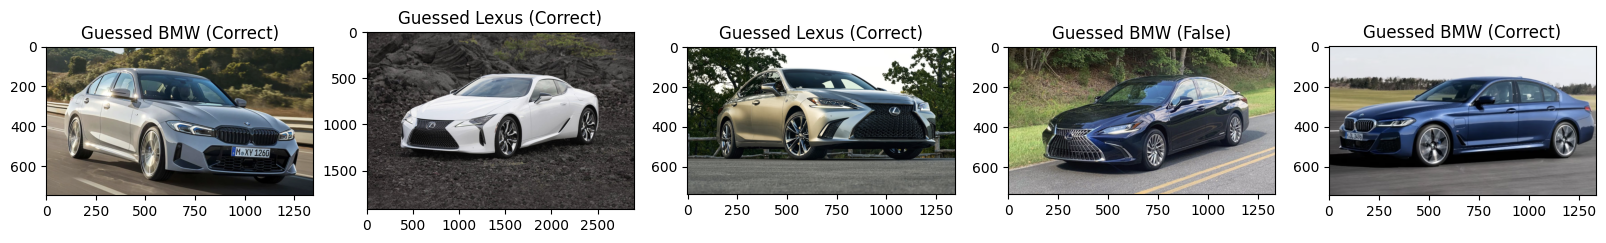

In [28]:
untrained_images_dir = "Cars Dataset/Untested Images"
tester = CarPredictionTester(car_classifier.model, untrained_images_dir)
tester.display_test_predictions()

### Evaluation of Prediction Results on Untested Images

Our model achieved impressive results on the untested image set, correctly identifying 4 out of 5 car brands. Specifically, it demonstrated perfect accuracy in identifying all the BMW images. The model only made one error in categorizing a Lexus image, misclassifying it as a BMW.

This level of accuracy—80% on this small subset—suggests that the model is robust and performs well, not only on the training and validation data but also on real-world, unseen data. While the misclassification of a Lexus as a BMW indicates that there's still room for improvement, the overall performance is highly encouraging and meets the project's success criteria.